In [2]:
!pip install graphviz

In [1]:
from sklearn import tree

In [2]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.tree import export_graphviz
import graphviz
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
import seaborn
import sklearn

In [3]:
#1.1a

In [4]:
raw_data = pd.read_csv("spotify_data.csv")
raw_data.head()

,Unnamed: 0,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,target,song_title,artist
0,0,0.0102,0.833,204600,0.434,0.021900,2,0.1650,-8.795,1,0.4310,150.062,4.0,0.286,1,Mask Off,Future
1,1,0.1990,0.743,326933,0.359,0.006110,1,0.1370,-10.401,1,0.0794,160.083,4.0,0.588,1,Redbone,Childish Gambino
2,2,0.0344,0.838,185707,0.412,0.000234,2,0.1590,-7.148,1,0.2890,75.044,4.0,0.173,1,Xanny Family,Future
3,3,0.6040,0.494,199413,0.338,0.510000,5,0.0922,-15.236,1,0.0261,86.468,4.0,0.230,1,Master Of None,Beach House
4,4,0.1800,0.678,392893,0.561,0.512000,5,0.4390,-11.648,0,0.0694,174.004,4.0,0.904,1,Parallel Lines,Junior Boys


In [5]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2017 entries, 0 to 2016
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        2017 non-null   int64  
 1   acousticness      2017 non-null   float64
 2   danceability      2017 non-null   float64
 3   duration_ms       2017 non-null   int64  
 4   energy            2017 non-null   float64
 5   instrumentalness  2017 non-null   float64
 6   key               2017 non-null   int64  
 7   liveness          2017 non-null   float64
 8   loudness          2017 non-null   float64
 9   mode              2017 non-null   int64  
 10  speechiness       2017 non-null   float64
 11  tempo             2017 non-null   float64
 12  time_signature    2017 non-null   float64
 13  valence           2017 non-null   float64
 14  target            2017 non-null   int64  
 15  song_title        2017 non-null   object 
 16  artist            2017 non-null   object 


- "Unnamed" column is just a useless column, it indexes  data from 0. 
- "song_title"  is not useful because it is unique, and is not useful for this binary classification problem
- since the highest numner of non unique entries is 16, we can drop "artist column". It comprisese less than 1% of the data -> not signifficant for the model



In [6]:
raw_data.groupby('artist').count().max()

Unnamed: 0          16
acousticness        16
danceability        16
duration_ms         16
energy              16
instrumentalness    16
key                 16
liveness            16
loudness            16
mode                16
speechiness         16
tempo               16
time_signature      16
valence             16
target              16
song_title          16
dtype: int64

In [7]:
df_dropped = raw_data.drop(columns=['Unnamed: 0', 'song_title', 'artist'])

In [8]:
# MAYBE REMOVE HIGHLY CORRELATED FEATURES

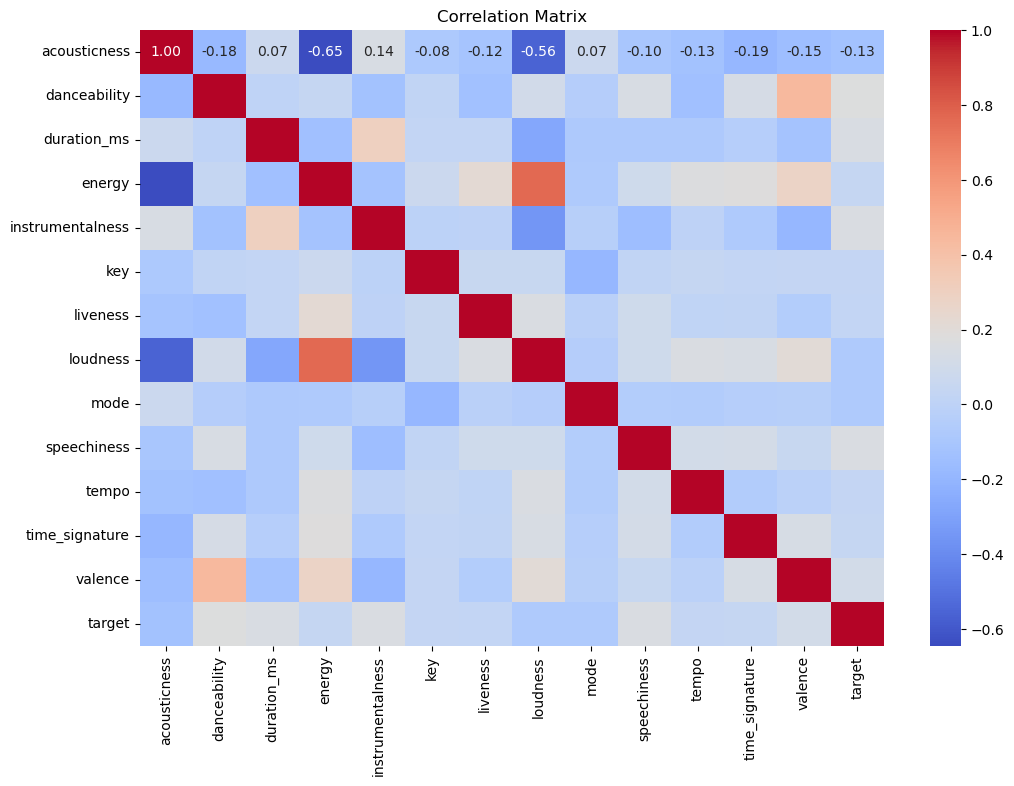

In [9]:
correlation_matrix = df_dropped.corr()

# Create a heatmap
plt.figure(figsize=(12, 8))
seaborn.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

In [10]:
y = df_dropped['target'] 
X = df_dropped.drop(columns=['target'])

In [11]:
from sklearn.feature_selection import mutual_info_classif
mutual_info = mutual_info_classif(X, y)
mutual_info

array([0.02760981, 0.04001359, 0.03879142, 0.01269855, 0.04449953,
       0.        , 0.        , 0.04952974, 0.        , 0.01622633,
       0.01834424, 0.        , 0.00609364])

In [12]:
column_names = X.columns.tolist()


In [13]:
#1.1b

Mutual information can tell us which features are useful and provide a uselfy insight(the lower the value, the more independent the feature is from the target(


<Figure size 1000x600 with 0 Axes>

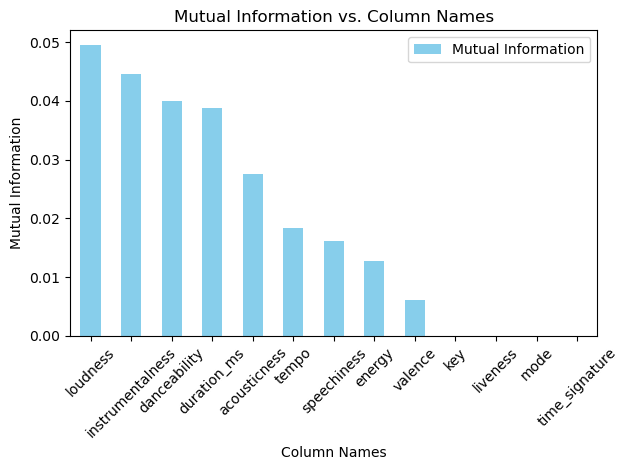

In [14]:
mutual_info_df = pd.DataFrame({'Column Names': column_names, 'Mutual Information': mutual_info})

# Create a bar plot
plt.figure(figsize=(10, 6))
mutual_info_df.sort_values(by='Mutual Information', ascending=False).plot(kind='bar', x='Column Names', y='Mutual Information', color='skyblue')
plt.title('Mutual Information vs. Column Names')
plt.xlabel('Column Names')
plt.ylabel('Mutual Information')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Based on this graph, features below 0.02 mutial information are not useful for analys since they provice almost no information about the target, which means that I will not consider features( their mutual information is low, so there is a low dependance of those columns on the target column, thus those features are not important): time_signature, tempo,energy,valence, speechiness, liveness, key, mode

In [15]:
mutual_info = mutual_info_classif(X, y)
mutual_info_df = pd.DataFrame({'Column Names': column_names, 'Mutual Information': mutual_info})
threshold = 0.02
selected_columns = mutual_info_df[mutual_info_df['Mutual Information'] > threshold]['Column Names']


In [16]:
selected_columns

0        acousticness
1        danceability
2         duration_ms
4    instrumentalness
7            loudness
Name: Column Names, dtype: object

In [17]:
#1.1c

In [18]:
X_selected = X[selected_columns]
X_selected

,acousticness,danceability,duration_ms,instrumentalness,loudness
0,0.01020,0.833,204600,0.021900,-8.795
1,0.19900,0.743,326933,0.006110,-10.401
2,0.03440,0.838,185707,0.000234,-7.148
3,0.60400,0.494,199413,0.510000,-15.236
4,0.18000,0.678,392893,0.512000,-11.648
...,...,...,...,...,...
2012,0.00106,0.584,274404,0.002690,-3.501
2013,0.08770,0.894,182182,0.001670,-2.663
2014,0.00857,0.637,207200,0.003990,-2.467
2015,0.00164,0.557,185600,0.677000,-2.735


In [19]:
y

0       1
1       1
2       1
3       1
4       1
       ..
2012    0
2013    0
2014    0
2015    0
2016    0
Name: target, Length: 2017, dtype: int64

In [20]:
#1.1d

In [21]:
x_train, x_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

In [22]:
#1.2 a

In [23]:
from sklearn.metrics import accuracy_score

clf = DecisionTreeClassifier(random_state=42)
clf.fit(x_train, y_train)
y_train_pred = clf.predict(x_train)
initial_train_accuracy = accuracy_score(y_train, y_train_pred)
print("Initial Training Accuracy:", initial_train_accuracy)

param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [5, 10, 15, 20, 25, 30],  
    'class_weight': [None, 'balanced'],
    'min_samples_split': [2, 4, 6, 8, 10], 
    'min_samples_leaf': [1, 2, 4, 6, 8],   
    'max_features': [None, 'auto', 'sqrt', 'log2']  
}

clf = DecisionTreeClassifier(random_state=42)
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
# Fit GridSearchCV to the Data
grid_search.fit(x_train, y_train)
print(best_params = grid_search.best_params_)

Initial Training Accuracy: 0.9993800371977681
Fitting 5 folds for each of 2400 candidates, totalling 12000 fits
[CV] END class_weight=None, criterion=gini, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END class_weight=None, criterion=gini, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=4; total time=   0.0s
[CV] END class_weight=None, criterion=gini, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=4; total time=   0.0s
[CV] END class_weight=None, criterion=gini, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=6; total time=   0.0s
[CV] END class_weight=None, criterion=gini, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=6; total time=   0.0s
[CV] END class_weight=None, criterion=gini, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=6; total time=   0.0s
[CV] END class_weight=None, criterion=gini, max_depth=5, max_features=No

[CV] END class_weight=None, criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=8; total time=   0.0s
[CV] END class_weight=None, criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=8; total time=   0.0s
[CV] END class_weight=None, criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10; total time=   0.0s
[CV] END class_weight=None, criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10; total time=   0.0s
[CV] END class_weight=None, criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10; total time=   0.0s
[CV] END class_weight=None, criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10; total time=   0.0s
[CV] END class_weight=None, criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10; total time=   0.0s
[CV] END class_weight=None, criterio

[CV] END class_weight=None, criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=2; total time=   0.0s
[CV] END class_weight=None, criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=2; total time=   0.0s
[CV] END class_weight=None, criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=4; total time=   0.0s
[CV] END class_weight=None, criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=4; total time=   0.0s
[CV] END class_weight=None, criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=4; total time=   0.0s
[CV] END class_weight=None, criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=4; total time=   0.0s
[CV] END class_weight=None, criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=4; total time=   0.0s
[CV] END class_weight=None, criterion=gin

[CV] END class_weight=None, criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2; total time=   0.0s
[CV] END class_weight=None, criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2; total time=   0.0s
[CV] END class_weight=None, criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2; total time=   0.0s
[CV] END class_weight=None, criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2; total time=   0.0s
[CV] END class_weight=None, criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2; total time=   0.0s
[CV] END class_weight=None, criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=4; total time=   0.0s
[CV] END class_weight=None, criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=4; total time=   0.0s
[CV] END class_weight=None, criterion=gin

[CV] END class_weight=None, criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2; total time=   0.0s
[CV] END class_weight=None, criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=4; total time=   0.0s
[CV] END class_weight=None, criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=4; total time=   0.0s
[CV] END class_weight=None, criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=4; total time=   0.0s
[CV] END class_weight=None, criterion=gini, max_depth=15, max_features=None, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END class_weight=None, criterion=gini, max_depth=15, max_features=None, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END class_weight=None, criterion=gini, max_depth=15, max_features=None, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END class_weight=None, criterion=gin

[CV] END class_weight=None, criterion=gini, max_depth=30, max_features=None, min_samples_leaf=4, min_samples_split=8; total time=   0.0s
[CV] END class_weight=None, criterion=gini, max_depth=30, max_features=None, min_samples_leaf=4, min_samples_split=10; total time=   0.0s
[CV] END class_weight=None, criterion=gini, max_depth=30, max_features=None, min_samples_leaf=4, min_samples_split=10; total time=   0.0s
[CV] END class_weight=None, criterion=gini, max_depth=30, max_features=None, min_samples_leaf=4, min_samples_split=10; total time=   0.0s
[CV] END class_weight=None, criterion=gini, max_depth=30, max_features=None, min_samples_leaf=4, min_samples_split=10; total time=   0.0s
[CV] END class_weight=None, criterion=gini, max_depth=30, max_features=None, min_samples_leaf=4, min_samples_split=10; total time=   0.0s
[CV] END class_weight=None, criterion=gini, max_depth=30, max_features=None, min_samples_leaf=6, min_samples_split=2; total time=   0.0s
[CV] END class_weight=None, criterio

[CV] END class_weight=None, criterion=gini, max_depth=30, max_features=sqrt, min_samples_leaf=8, min_samples_split=4; total time=   0.0s
[CV] END class_weight=None, criterion=gini, max_depth=30, max_features=sqrt, min_samples_leaf=8, min_samples_split=4; total time=   0.0s
[CV] END class_weight=None, criterion=gini, max_depth=30, max_features=sqrt, min_samples_leaf=8, min_samples_split=4; total time=   0.0s
[CV] END class_weight=None, criterion=gini, max_depth=30, max_features=sqrt, min_samples_leaf=8, min_samples_split=4; total time=   0.0s
[CV] END class_weight=None, criterion=gini, max_depth=30, max_features=sqrt, min_samples_leaf=8, min_samples_split=6; total time=   0.0s
[CV] END class_weight=None, criterion=gini, max_depth=30, max_features=sqrt, min_samples_leaf=8, min_samples_split=6; total time=   0.0s
[CV] END class_weight=None, criterion=gini, max_depth=30, max_features=sqrt, min_samples_leaf=8, min_samples_split=6; total time=   0.0s
[CV] END class_weight=None, criterion=gin

[CV] END class_weight=None, criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=6; total time=   0.0s
[CV] END class_weight=None, criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=6; total time=   0.0s
[CV] END class_weight=None, criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=6; total time=   0.0s
[CV] END class_weight=None, criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=8; total time=   0.0s
[CV] END class_weight=None, criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=8; total time=   0.0s
[CV] END class_weight=None, criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=8; total time=   0.0s
[CV] END class_weight=None, criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=8; total time=   0.0s
[CV] END class_weight=None,

[CV] END class_weight=None, criterion=entropy, max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=2; total time=   0.0s
[CV] END class_weight=None, criterion=entropy, max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=2; total time=   0.0s
[CV] END class_weight=None, criterion=entropy, max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=4; total time=   0.0s
[CV] END class_weight=None, criterion=entropy, max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=4; total time=   0.0s
[CV] END class_weight=None, criterion=entropy, max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=4; total time=   0.0s
[CV] END class_weight=None, criterion=entropy, max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=4; total time=   0.0s
[CV] END class_weight=None, criterion=entropy, max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=4; total time=   0.0s
[CV] END class_weigh

[CV] END class_weight=None, criterion=entropy, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=8; total time=   0.0s
[CV] END class_weight=None, criterion=entropy, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=8; total time=   0.0s
[CV] END class_weight=None, criterion=entropy, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=10; total time=   0.0s
[CV] END class_weight=None, criterion=entropy, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=10; total time=   0.0s
[CV] END class_weight=None, criterion=entropy, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=10; total time=   0.0s
[CV] END class_weight=None, criterion=entropy, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=10; total time=   0.0s
[CV] END class_weight=None, criterion=entropy, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=10; total time=   0.0s
[CV] END class_

[CV] END class_weight=None, criterion=entropy, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=4; total time=   0.0s
[CV] END class_weight=None, criterion=entropy, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=4; total time=   0.0s
[CV] END class_weight=None, criterion=entropy, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=4; total time=   0.0s
[CV] END class_weight=None, criterion=entropy, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=4; total time=   0.0s
[CV] END class_weight=None, criterion=entropy, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=4; total time=   0.0s
[CV] END class_weight=None, criterion=entropy, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=6; total time=   0.0s
[CV] END class_weight=None, criterion=entropy, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=6; total time=   0.0s
[CV] END class_weigh

[CV] END class_weight=None, criterion=entropy, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=6; total time=   0.0s
[CV] END class_weight=None, criterion=entropy, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=6; total time=   0.0s
[CV] END class_weight=None, criterion=entropy, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=6; total time=   0.0s
[CV] END class_weight=None, criterion=entropy, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=8; total time=   0.0s
[CV] END class_weight=None, criterion=entropy, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=8; total time=   0.0s
[CV] END class_weight=None, criterion=entropy, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=8; total time=   0.0s
[CV] END class_weight=None, criterion=entropy, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=8; total time=   0.0s
[CV] END class_weigh

[CV] END class_weight=None, criterion=entropy, max_depth=30, max_features=sqrt, min_samples_leaf=8, min_samples_split=8; total time=   0.0s
[CV] END class_weight=None, criterion=entropy, max_depth=30, max_features=sqrt, min_samples_leaf=8, min_samples_split=8; total time=   0.0s
[CV] END class_weight=None, criterion=entropy, max_depth=30, max_features=sqrt, min_samples_leaf=8, min_samples_split=10; total time=   0.0s
[CV] END class_weight=None, criterion=entropy, max_depth=30, max_features=sqrt, min_samples_leaf=8, min_samples_split=10; total time=   0.0s
[CV] END class_weight=None, criterion=entropy, max_depth=30, max_features=sqrt, min_samples_leaf=8, min_samples_split=10; total time=   0.0s
[CV] END class_weight=None, criterion=entropy, max_depth=30, max_features=sqrt, min_samples_leaf=8, min_samples_split=10; total time=   0.0s
[CV] END class_weight=None, criterion=entropy, max_depth=30, max_features=sqrt, min_samples_leaf=8, min_samples_split=10; total time=   0.0s
[CV] END class_

[CV] END class_weight=None, criterion=entropy, max_depth=30, max_features=log2, min_samples_leaf=2, min_samples_split=10; total time=   0.0s
[CV] END class_weight=None, criterion=entropy, max_depth=30, max_features=log2, min_samples_leaf=4, min_samples_split=2; total time=   0.0s
[CV] END class_weight=None, criterion=entropy, max_depth=30, max_features=log2, min_samples_leaf=4, min_samples_split=2; total time=   0.0s
[CV] END class_weight=None, criterion=entropy, max_depth=30, max_features=log2, min_samples_leaf=4, min_samples_split=2; total time=   0.0s
[CV] END class_weight=None, criterion=entropy, max_depth=30, max_features=log2, min_samples_leaf=4, min_samples_split=2; total time=   0.0s
[CV] END class_weight=None, criterion=entropy, max_depth=30, max_features=log2, min_samples_leaf=4, min_samples_split=2; total time=   0.0s
[CV] END class_weight=None, criterion=entropy, max_depth=30, max_features=log2, min_samples_leaf=4, min_samples_split=4; total time=   0.0s
[CV] END class_weig

[CV] END class_weight=balanced, criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=8; total time=   0.0s
[CV] END class_weight=balanced, criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=8; total time=   0.0s
[CV] END class_weight=balanced, criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=8; total time=   0.0s
[CV] END class_weight=balanced, criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=10; total time=   0.0s
[CV] END class_weight=balanced, criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=10; total time=   0.0s
[CV] END class_weight=balanced, criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=10; total time=   0.0s
[CV] END class_weight=balanced, criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=10; total time=   0.0s
[CV] END class_w

[CV] END class_weight=None, criterion=entropy, max_depth=25, max_features=None, min_samples_leaf=8, min_samples_split=6; total time=   0.0s
[CV] END class_weight=None, criterion=entropy, max_depth=25, max_features=None, min_samples_leaf=8, min_samples_split=6; total time=   0.0s
[CV] END class_weight=None, criterion=entropy, max_depth=25, max_features=None, min_samples_leaf=8, min_samples_split=6; total time=   0.0s
[CV] END class_weight=None, criterion=entropy, max_depth=25, max_features=None, min_samples_leaf=8, min_samples_split=8; total time=   0.0s
[CV] END class_weight=None, criterion=entropy, max_depth=25, max_features=None, min_samples_leaf=8, min_samples_split=8; total time=   0.0s
[CV] END class_weight=None, criterion=entropy, max_depth=25, max_features=None, min_samples_leaf=8, min_samples_split=8; total time=   0.0s
[CV] END class_weight=None, criterion=entropy, max_depth=25, max_features=None, min_samples_leaf=8, min_samples_split=8; total time=   0.0s
[CV] END class_weigh

[CV] END class_weight=balanced, criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=8, min_samples_split=10; total time=   0.0s[CV] END class_weight=balanced, criterion=gini, max_depth=10, max_features=None, min_samples_leaf=2, min_samples_split=2; total time=   0.0s
[CV] END class_weight=balanced, criterion=gini, max_depth=10, max_features=None, min_samples_leaf=2, min_samples_split=2; total time=   0.0s
[CV] END class_weight=balanced, criterion=gini, max_depth=10, max_features=None, min_samples_leaf=2, min_samples_split=2; total time=   0.0s
[CV] END class_weight=balanced, criterion=gini, max_depth=10, max_features=None, min_samples_leaf=2, min_samples_split=4; total time=   0.0s
[CV] END class_weight=balanced, criterion=gini, max_depth=10, max_features=None, min_samples_leaf=2, min_samples_split=4; total time=   0.0s
[CV] END class_weight=balanced, criterion=gini, max_depth=10, max_features=None, min_samples_leaf=2, min_samples_split=4; total time=   0.0s
[CV] END clas

[CV] END class_weight=balanced, criterion=gini, max_depth=25, max_features=sqrt, min_samples_leaf=4, min_samples_split=4; total time=   0.0s
[CV] END class_weight=balanced, criterion=gini, max_depth=25, max_features=sqrt, min_samples_leaf=4, min_samples_split=4; total time=   0.0s
[CV] END class_weight=balanced, criterion=gini, max_depth=25, max_features=sqrt, min_samples_leaf=4, min_samples_split=6; total time=   0.0s
[CV] END class_weight=balanced, criterion=gini, max_depth=25, max_features=sqrt, min_samples_leaf=4, min_samples_split=6; total time=   0.0s
[CV] END class_weight=balanced, criterion=gini, max_depth=25, max_features=sqrt, min_samples_leaf=4, min_samples_split=6; total time=   0.0s
[CV] END class_weight=balanced, criterion=gini, max_depth=25, max_features=sqrt, min_samples_leaf=4, min_samples_split=6; total time=   0.0s
[CV] END class_weight=balanced, criterion=gini, max_depth=25, max_features=sqrt, min_samples_leaf=4, min_samples_split=6; total time=   0.0s
[CV] END clas

[CV] END class_weight=balanced, criterion=gini, max_depth=25, max_features=None, min_samples_leaf=4, min_samples_split=6; total time=   0.0s
[CV] END class_weight=balanced, criterion=gini, max_depth=25, max_features=None, min_samples_leaf=4, min_samples_split=8; total time=   0.0s
[CV] END class_weight=balanced, criterion=gini, max_depth=25, max_features=None, min_samples_leaf=4, min_samples_split=8; total time=   0.0s
[CV] END class_weight=balanced, criterion=gini, max_depth=25, max_features=None, min_samples_leaf=4, min_samples_split=8; total time=   0.0s
[CV] END class_weight=balanced, criterion=gini, max_depth=25, max_features=None, min_samples_leaf=4, min_samples_split=8; total time=   0.0s
[CV] END class_weight=balanced, criterion=gini, max_depth=25, max_features=None, min_samples_leaf=4, min_samples_split=8; total time=   0.0s
[CV] END class_weight=balanced, criterion=gini, max_depth=25, max_features=None, min_samples_leaf=4, min_samples_split=10; total time=   0.0s
[CV] END cla

[CV] END class_weight=balanced, criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=4, min_samples_split=8; total time=   0.0s
[CV] END class_weight=balanced, criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=4, min_samples_split=8; total time=   0.0s
[CV] END class_weight=balanced, criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=4, min_samples_split=8; total time=   0.0s
[CV] END class_weight=balanced, criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=4, min_samples_split=8; total time=   0.0s
[CV] END class_weight=balanced, criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=4, min_samples_split=10; total time=   0.0s
[CV] END class_weight=balanced, criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=4, min_samples_split=10; total time=   0.0s
[CV] END class_weight=balanced, criterion=entropy, max_depth=5, max_features=log2, min_samples_leaf=4, min_samples_split=10; total time=   0

[CV] END class_weight=balanced, criterion=gini, max_depth=30, max_features=sqrt, min_samples_leaf=6, min_samples_split=4; total time=   0.0s
[CV] END class_weight=balanced, criterion=gini, max_depth=30, max_features=sqrt, min_samples_leaf=6, min_samples_split=6; total time=   0.0s
[CV] END class_weight=balanced, criterion=gini, max_depth=30, max_features=sqrt, min_samples_leaf=6, min_samples_split=6; total time=   0.0s
[CV] END class_weight=balanced, criterion=gini, max_depth=30, max_features=sqrt, min_samples_leaf=6, min_samples_split=6; total time=   0.0s
[CV] END class_weight=balanced, criterion=gini, max_depth=30, max_features=sqrt, min_samples_leaf=6, min_samples_split=6; total time=   0.0s
[CV] END class_weight=balanced, criterion=gini, max_depth=30, max_features=sqrt, min_samples_leaf=6, min_samples_split=6; total time=   0.0s
[CV] END class_weight=balanced, criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=8, min_samples_split=6; total time=   0.0s
[CV] END c

[CV] END class_weight=balanced, criterion=entropy, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=8; total time=   0.0s
[CV] END class_weight=balanced, criterion=entropy, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=8; total time=   0.0s
[CV] END class_weight=balanced, criterion=entropy, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=8; total time=   0.0s
[CV] END class_weight=balanced, criterion=entropy, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=8; total time=   0.0s
[CV] END class_weight=balanced, criterion=entropy, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=8; total time=   0.0s
[CV] END class_weight=balanced, criterion=entropy, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=10; total time=   0.0s
[CV] END class_weight=balanced, criterion=entropy, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=10; total time=   0.

[CV] END class_weight=balanced, criterion=entropy, max_depth=20, max_features=None, min_samples_leaf=2, min_samples_split=6; total time=   0.0s[CV] END class_weight=balanced, criterion=gini, max_depth=30, max_features=None, min_samples_leaf=2, min_samples_split=8; total time=   0.0s
[CV] END class_weight=balanced, criterion=gini, max_depth=30, max_features=None, min_samples_leaf=2, min_samples_split=10; total time=   0.0s
[CV] END class_weight=balanced, criterion=gini, max_depth=30, max_features=None, min_samples_leaf=2, min_samples_split=10; total time=   0.0s
[CV] END class_weight=balanced, criterion=gini, max_depth=30, max_features=None, min_samples_leaf=2, min_samples_split=10; total time=   0.0s
[CV] END class_weight=balanced, criterion=gini, max_depth=30, max_features=None, min_samples_leaf=2, min_samples_split=10; total time=   0.0s
[CV] END class_weight=balanced, criterion=gini, max_depth=30, max_features=None, min_samples_leaf=2, min_samples_split=10; total time=   0.0s
[CV] E

[CV] END class_weight=balanced, criterion=entropy, max_depth=25, max_features=auto, min_samples_leaf=4, min_samples_split=8; total time=   0.0s
[CV] END class_weight=balanced, criterion=entropy, max_depth=25, max_features=auto, min_samples_leaf=4, min_samples_split=10; total time=   0.0s
[CV] END class_weight=balanced, criterion=entropy, max_depth=25, max_features=auto, min_samples_leaf=4, min_samples_split=10; total time=   0.0s
[CV] END class_weight=balanced, criterion=entropy, max_depth=25, max_features=auto, min_samples_leaf=4, min_samples_split=10; total time=   0.0s
[CV] END class_weight=balanced, criterion=entropy, max_depth=25, max_features=auto, min_samples_leaf=4, min_samples_split=10; total time=   0.0s
[CV] END class_weight=balanced, criterion=entropy, max_depth=25, max_features=auto, min_samples_leaf=4, min_samples_split=10; total time=   0.0s
[CV] END class_weight=balanced, criterion=entropy, max_depth=25, max_features=auto, min_samples_leaf=6, min_samples_split=2; total 

[CV] END class_weight=balanced, criterion=entropy, max_depth=10, max_features=None, min_samples_leaf=4, min_samples_split=4; total time=   0.0s
[CV] END class_weight=balanced, criterion=entropy, max_depth=10, max_features=None, min_samples_leaf=4, min_samples_split=6; total time=   0.0s
[CV] END class_weight=balanced, criterion=entropy, max_depth=10, max_features=None, min_samples_leaf=4, min_samples_split=6; total time=   0.0s
[CV] END class_weight=balanced, criterion=entropy, max_depth=10, max_features=None, min_samples_leaf=4, min_samples_split=6; total time=   0.0s
[CV] END class_weight=balanced, criterion=entropy, max_depth=10, max_features=None, min_samples_leaf=4, min_samples_split=6; total time=   0.0s
[CV] END class_weight=balanced, criterion=entropy, max_depth=10, max_features=None, min_samples_leaf=4, min_samples_split=6; total time=   0.0s
[CV] END class_weight=balanced, criterion=entropy, max_depth=10, max_features=None, min_samples_leaf=4, min_samples_split=8; total time=

/Users/gman/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
3000 fits failed out of a total of 12000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1125 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/gman/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/gman/anaconda3/lib/python3.11/site-packages/sklearn/base.py", line 1145, in wrapper
    estimator._validate_params()
  File "/Users/gman/anaconda3/lib/python3.11/site-packages/sklearn/base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "/Use

TypeError: 'best_params' is an invalid keyword argument for print()

In [24]:
print("Hyperparameters I searched over are:")
print('\ncriterion\nmax_depth\nclass_weight\nmin_samples_split\nmin_samples_leaf\nmax_features\n')

best_params = grid_search.best_params_
print("Best parameters:", best_params)


Hyperparameters I searched over are:

criterion
max_depth
class_weight
min_samples_split
min_samples_leaf
max_features

Best parameters: {'class_weight': None, 'criterion': 'gini', 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 10}


In [25]:
#1.2 b

In [26]:
best_model = grid_search.best_estimator_
test_accuracy = best_model.score(x_test, y_test)
print("Test accuracy:", test_accuracy)

Test accuracy: 0.7029702970297029


In [27]:
#1.3 a

In [28]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

y_pred = best_model.predict(x_test)
precision = precision_score(y_test, y_pred, average='binary')
recall = recall_score(y_test, y_pred, average='binary')
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='binary')

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")

Precision: 0.6875
Recall: 0.7222222222222222
Accuracy: 0.7029702970297029
F1 Score: 0.7044334975369457


In [29]:
#1.3 b

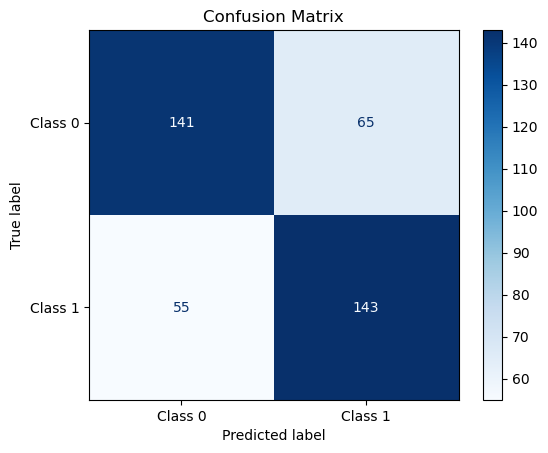

In [30]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_test_array = y_test.to_numpy() # convert to array
cm = confusion_matrix(y_test_array, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Class 0', 'Class 1'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

There are 143 true positives, 141 true negatives, 65 false positives, and 55 false negatives in this confusion matrix

In [31]:
#1.3 c

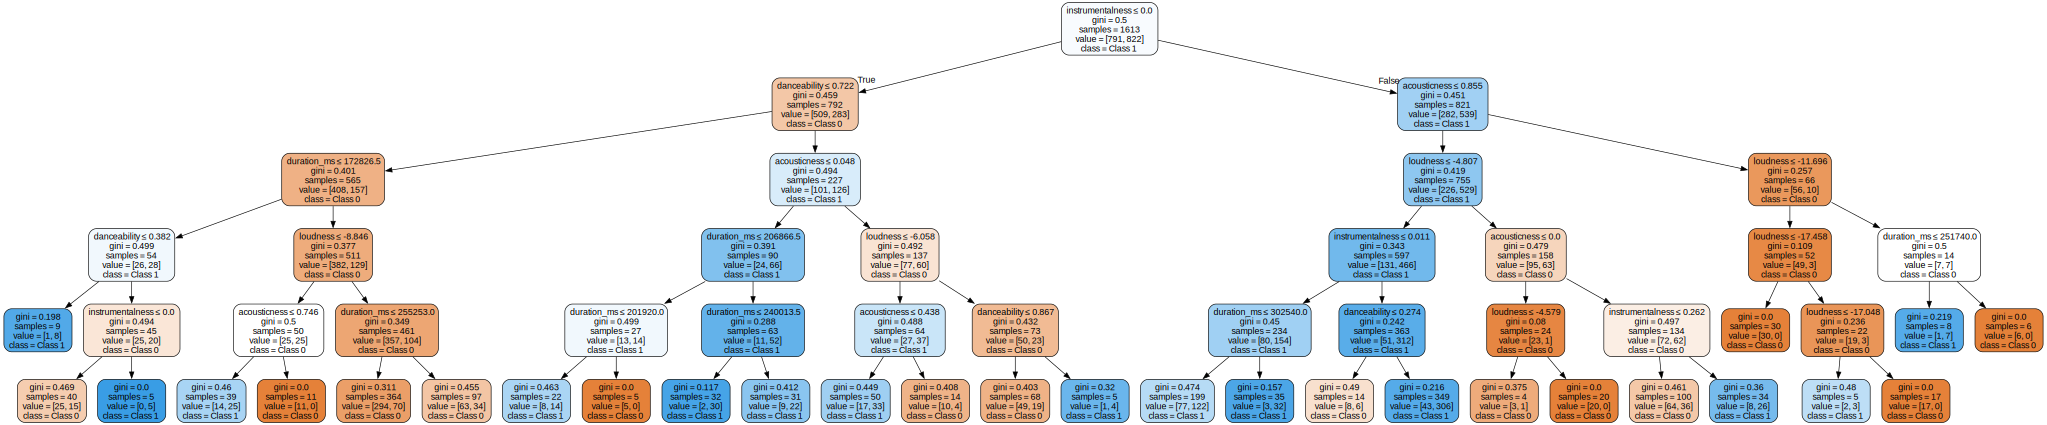

'Source.gv.pdf'

In [34]:
from sklearn.tree import export_graphviz
from sklearn import tree
import graphviz
from IPython.display import display

# Export as dot file
dot_data = tree.export_graphviz(best_model, out_file=None, 
                                feature_names=X_selected.columns,  
                                class_names=['Class 0', 'Class 1'],
                                filled=True, rounded=True,  
                                special_characters=True)  


graph = graphviz.Source(dot_data)
display(graph)
graph = graphviz.Source(dot_data)  
graph.view()


This descision tree conceptualizes the weight importance of each feature at the split. The numerical representation can be found in the next cell. It has 5 levels (excluding gini) which maps on the number of features we are trying to split the data in.

In [33]:
#1.3 d
importances = best_model.feature_importances_
feature_names = X_selected.columns
for name, importance in zip(feature_names, importances):
    print(f"{name}: {importance}")

acousticness: 0.22606854333582913
danceability: 0.12755213864588047
duration_ms: 0.10656922276888946
instrumentalness: 0.3404295220564907
loudness: 0.19938057319291028


Since each vaue represents the weight of particular feature in determining the splits in the decision tree, we conclude that the most important feature list follows in this descending order (from most important to least important):
- instrumentalness
- acousticness 
- loudness 
- danceability
- duration_ms

In Q1.1, we determined that most relevant features are (in descending order):
- loudness
- dancability
- duration_m
- instrumentalness 
- acousticness 

This ranking was basd on the mutual information

It is clear that the qualitative estimates based on the mutiual information are drastically different from the decision tree feature importance. It is important to note that different metrixs were used to derive the relevance of the features (mutual information measures the reduction in uncertainty for the target variable given a feature, while feature importance measures the weighted average of the reduction in the chosen criterion by a feature across all nodes where the feature is used to make a split). Also note that feature importances derived from the decision tree are dependent on the model's structure. If a feature appears near the top of the tree, it will have a larger importance in the decision tree because it influences all the splits below it, even if the mutual information is not the highest.